# Investigation of currents in the pool during the 2013 FINA World Championships


Several coaches, competitors, and fans claimed the temporary pool used for the 2013 FINA World Championships had a "current" that gave competitors in certain lanes an advantage. We will be examining data from the semifinals and finals of 2013 and 2015 World championships for all four strokes (back, breast, butterfly, and free) to look for lane bias.

Is there a change in times as swimmers change from low number lanes (1-3) to high number lanes (6-8) in the semis and finals?
![pool](currents.jpg)
A good metric for measuring an individual swimmer's improvements from in each round would be The fractional improvement of swim time: (t<sub>a</sub> - t<sub>b</sub>) / t<sub>a</sub> 



*t<sub>a</sub> - swim time in a lower numbered lane and t<sub>b</sub> - swim time in a higher lane.

*Image courtesy of the Chicago Tribune

In [117]:
import pandas as pd
from pandas_summary import DataFrameSummary
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)

In [73]:
# Create dataframes for the 2013 and 2015 FINA results: fina_13, fina_15
fina_13 = pd.read_csv('2013_FINA.csv')
fina_15 = pd.read_csv('2015_FINA.csv')

# Create dataframes for all swimmers who semifinal in a low numbered lane and the final in a high numbered lane
# or vice-versa
# Semifinal = 'SEMI', Final = 'FIN"
rounds = ['SEM', 'FIN']
df = fina_13[fina_13['round'].isin(rounds)]
#dfs = DataFrameSummary(df)
print(dfs['round'])
low_lanes = [1, 2, 3]
high_lanes = [6, 7, 8]

low_start = df[(df['round']=='SEMI')]
df.head()

"FIN" count       1504
"FIN" perc      59.49%
"SEM" count       1024
"SEM" perc      40.51%
counts            2528
uniques              2
missing              0
missing_perc        0%
types             bool
Name: round, dtype: object


,athleteid,lastname,firstname,birthdate,gender,name,code,eventid,heat,lane,points,reactiontime,swimtime,split,cumswimtime,splitdistance,daytime,round,distance,relaycount,stroke,splitswimtime
118,247672,GRABICH,FEDERICO,1/1/1990,M,ARGENTINA,ARG,234,2,8,872.0,0.57,25.16,1,25.16,50,1915.0,SEM,50,1,BACK,25.16
201,244081,ABOOD,MATTHEW,1/1/1986,M,AUSTRALIA,AUS,227,1,5,872.0,0.73,21.91,1,21.91,50,1838.0,SEM,50,1,FREE,21.91
230,244091,BARRATT,BRONTE,1/1/1989,F,AUSTRALIA,AUS,215,2,6,896.0,0.67,117.18,1,27.79,50,1914.0,SEM,200,1,FREE,27.79
231,244091,BARRATT,BRONTE,1/1/1989,F,AUSTRALIA,AUS,215,2,6,896.0,0.67,117.18,2,57.28,100,1914.0,SEM,200,1,FREE,29.49
232,244091,BARRATT,BRONTE,1/1/1989,F,AUSTRALIA,AUS,215,2,6,896.0,0.67,117.18,3,87.24,150,1914.0,SEM,200,1,FREE,29.96


We will begin by examining times for all swimmers who swam 50m semifinal and final races

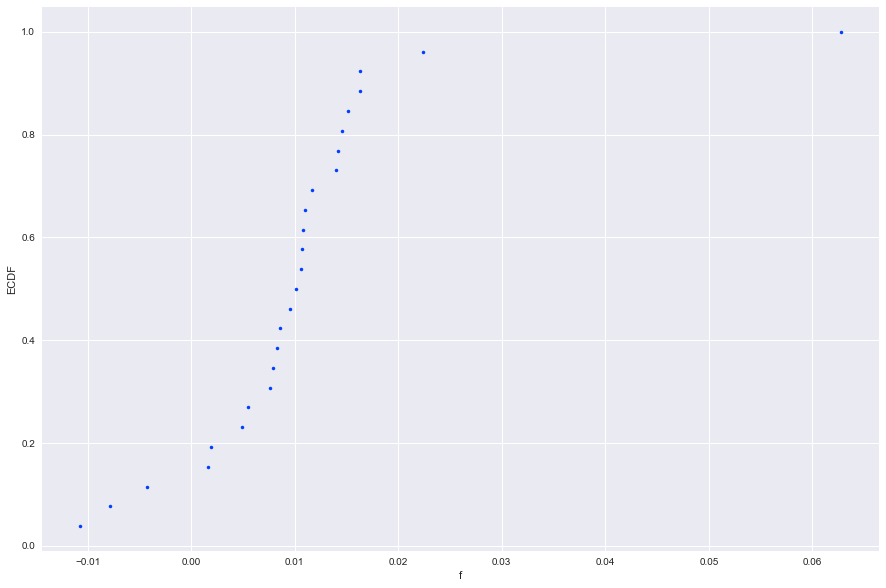

In [82]:
# Create arrays for the swim times of all swimmers who swam a 50 m semifinal in a high numbered lane
# and the final in a low numbered lane, and vice versa: swimtime_high_lanes, swimtime_low_lanes
swimtime_high_lanes = np.array([24.62, 22.9 , 27.05, 24.76, 30.31, 24.54, 26.12, 27.71, 23.15,
       23.11, 21.62, 28.02, 24.73, 24.95, 25.83, 30.61, 27.04, 21.67,
       27.16, 30.23, 21.51, 22.97, 28.05, 21.65, 24.54, 26.06])

swimtime_low_lanes = np.array([24.66, 23.28, 27.2 , 24.95, 32.34, 24.66, 26.17, 27.93, 23.35,
       22.93, 21.93, 28.33, 25.14, 25.19, 26.11, 31.31, 27.44, 21.85,
       27.48, 30.66, 21.74, 23.22, 27.93, 21.42, 24.79, 26.46])

# Compute the fractional improvement of being in a high lane: f
f = (swimtime_low_lanes - swimtime_high_lanes) / swimtime_low_lanes

# Make x and y values for ECDF: x, y
x, y = dcst.ecdf(f)

# Plot the ECDF
plt.figure(figsize=(15, 10))
plt.style.use('seaborn-bright')
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('f')
plt.ylabel('ECDF')
plt.show()

The ECDF demonstrates that all but three of the 26 swimmers swam faster in the high numbered lanes.

Now we need to estimate (using bootstrap replicates be cause we have a limited number of samples) the mean improvement in the times. In other words, how big is the current effect?

In [83]:
# Compute the mean difference: f_mean
f_mean = np.mean(f)

# Draw 10,000 boptstrap replicates: bs_reps
bs_reps = dcst.draw_bs_reps(f, np.mean, size=10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Print the result
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]""".format(f_mean, *conf_int))


mean frac. diff.: 0.01051
95% conf int of mean frac. diff.: [0.00607, 0.01601]


For the 50m distances, it looks like swimmers are faster in lanes 6-8.

## Does lane assignment affect performance?
Our null hypothesis is that the mean fractional improvement going from low to high lane numbers is zero. We can test the hypothese by subtracting the mean of f from f to generate our test statistic (f_shift). Then we will take bootstrap replicates from f_shift

In [95]:
# Shift f: f_shift
f_shift = f - f_mean

# Draw 10,000 bs replicates of the mean of f_shift: bs_reps
bs_reps = dcst.draw_bs_reps(f_shift, np.mean, size=10000)

# Compute and report the p-value: p_val
p_val = np.sum(bs_reps >= f_mean) / 100000
print('p =', "%.5f" % p_val)

p = 0.00004


The small p-value suggests that the mean fractional improvement is greater than zero.

## Did the 2015 FINA World Championships have the same problem?
We can perform a similar analysis for the results of the 2015 Championships and compare our findings

In [99]:
# Create arrays for the swim times in the high and low lanes: swimtime_high_lanes_15, swimtime_low_lanes_15
swimtime_high_lanes_15 = np.array([27.7 , 24.64, 23.21, 23.09, 26.87, 30.74, 21.88, 24.5 , 21.86,
       25.9 , 26.2 , 24.73, 30.13, 26.92, 24.31, 30.25, 26.76])

swimtime_low_lanes_15 = np.array([27.66, 24.69, 23.29, 23.05, 26.87, 31.03, 22.04, 24.51, 21.86,
       25.64, 25.91, 24.77, 30.14, 27.23, 24.31, 30.2 , 26.86])

# Compute the f and its mean: f, f_mean
f = (swimtime_low_lanes_15 - swimtime_high_lanes_15) / swimtime_low_lanes_15
f_mean = np.mean(f)

# Draw 10,000 bootstrap replicates of the mean of f: bs_reps
bs_reps = dcst.draw_bs_reps(f, np.mean, size=10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Shift f: f_shift
f_shift = f - f_mean

# Draw 10,000 bootstrap replicates of the mean of f_shift
bs_reps = dcst.draw_bs_reps(f_shift, np.mean, size=10000)

# Compute the p-value: p_val
p_val = np.sum(bs_reps >= f_mean) / 10000

# Print the results
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]
p-value: {3:.5f}""".format(f_mean, *conf_int,p_val))


mean frac. diff.: 0.00079
95% conf int of mean frac. diff.: [-0.00193, 0.00333]
p-value: 0.28210


Both the confidence intervals and p-value suggest that there was no lane bias in 2015.

So far, we have seen evidence of a swirling current in 2013 based on perfomance in 50 meter events. The next step is to examine how a current would affect the splits in longer races. The longest race in the world championships is the 1500m freestyle, with the swimmers swiming the pool 15 times in each direction.

If there is a current, we would expect swimmers in lanes 1-3 to have fast even splits when swimming with the current and slow odd splits when swimming against the current (i.e. a "zig-zag" effect).

Our analysis of the splits in the 1500m races will exclude the first two and last two splits. We are excluding the first two splits because the swimmers are starting from the blocks and spend swim underwater for a while. The last two splits are excluded because it is assumed that the swimmers will have stopped pacing themselves and "kick" for the final stretch.
![first_lap](underwater.jpg)

*Image courtesty of Reuters

## EDA
Unlike the data for the 50m races, the 1500m races have actual time splits for laps. Therefore, we are considering both improvement and decline in performance depending on the direction of swimming. So, we will define the fractional difference as f = 2(t$_{a}$ - t$_{b}$) / (t$_{a}$ + t$_{b}$) because we want to reference the average.

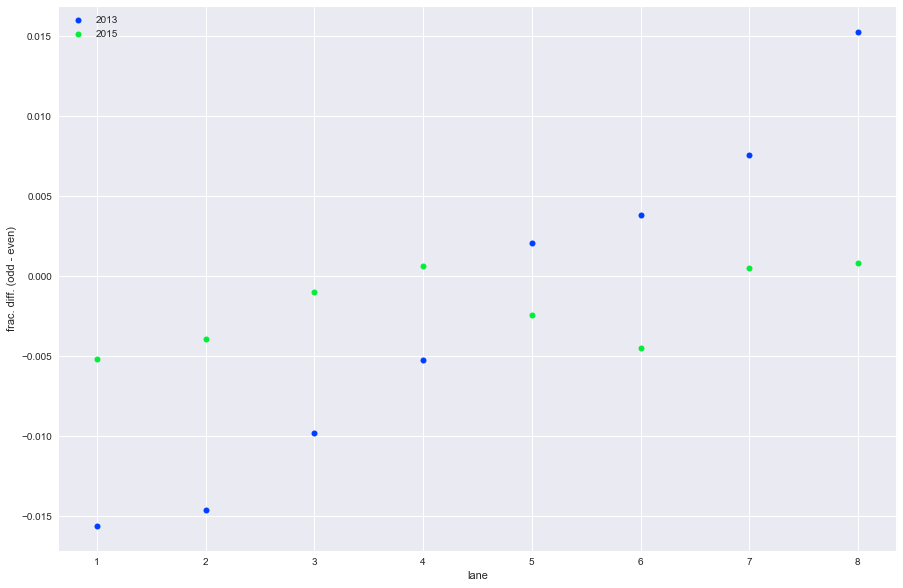

In [104]:
# Create an array of lane numbers:lanes
lanes = np.array([1, 2, 3, 4, 5, 6, 7, 8])

# Create arrays for the mean fractional differences for the 2013 and 2015 Worlds: f_13, f_15
f_13 = np.array([-0.01562214, -0.0146381, -0.00977673, -0.00525713, 0.00204104,
                 0.00381014,  0.0075664 ,  0.01525869])

f_15 = np.array([-0.00516018, -0.00392952, -0.00099284,  0.00059953, -0.002424,
                 -0.00451099,  0.00047467,  0.00081962])

# Plot the fractional difference for 2013 and 2015
plt.figure(figsize=(15, 10))
plt.plot(lanes, f_13, marker='.', markersize=12, linestyle='none')
plt.plot(lanes, f_15, marker='.', markersize=12, linestyle='none')
plt.legend((2013, 2015))
plt.xlabel('lane')
plt.ylabel('frac. diff. (odd - even)')
plt.show()

There is a strong slope in 2013 compared to 2015.

We need to perform a linear regression on f_13 vs lane in order to quantify the effect of lane number on performance


slope: 0.00447 per lane
95% conf int: [0.00393, 0.00502] per lane


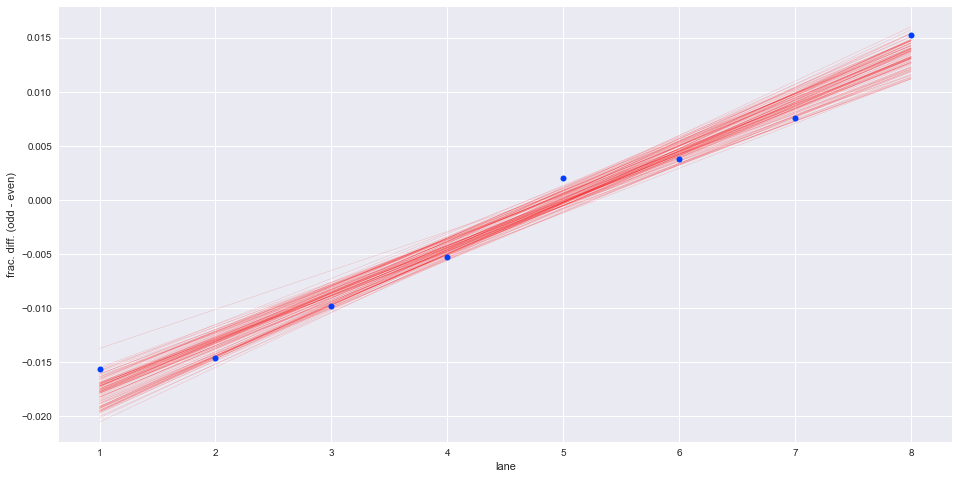

In [119]:
# Compute the slope and intercept of the f_13 vs lanes curve: slope, intercept
slope, intercept = np.polyfit(lanes, f_13, 1)

# Compute bootstrap replicates of the slope and intercept: bs_reps_slope, bs_reps_int
bs_reps_slope, bs_reps_int = dcst.draw_bs_pairs_linreg(lanes, f_13, size=10000)

# Compute the 95% confidence interval of slope: conf_int
conf_int = np.percentile(bs_reps_slope, [2.5, 97.5])

# Print slope and confidence interval
print("""
slope: {0:.5f} per lane
95% conf int: [{1:.5f}, {2:.5f}] per lane""".format(slope, *conf_int))

# Generate the x values for plotting the bootstrap lines: x
x = np.array([1, 8])

# Plot 100 bootstrap replicate lines
for i in range(100):
        _ = plt.plot(x, bs_reps_slope[i] * x + bs_reps_int[i], color='red', alpha=0.2, linewidth=0.5)

# Update the plot
plt.plot(lanes, f_13, marker='.', markersize=12, linestyle='none')
plt.xlabel('lane')
plt.ylabel('frac. diff. (odd - even)')
plt.draw()
plt.show()


World class races are decided by fractions of a second as evinced by the precision with which the results are timed. The slope is a fractional difference of ~ 0.4% per lane, which amounts to a huge difference at this level of competition.

Now, we need to test the alternative hypothesis that lane assignment has nothing to do with the mean fractional difference between even and odd lanes. This will be done using a permutation test and Pearson's r (the Pearson correlation coefficient) will be the test statistic.

In [125]:
# Compute the observed Pearson's r: rho
rho = dcst.pearson_r(lanes, f_13)

# Initialize an empty arrayy to store 10,000 permutation replicates: perm_reps_rho
perm_reps_rho = (np.empty(10000))

# Draw the permutation replicates
for i in range(10000):
    # Scramble the lane array: scrambled_lanes
    scrambled_lanes = np.random.permutation(lanes)
    
    # Compute the Pearson correlation coefficient
    perm_reps_rho[i] = dcst.pearson_r(scrambled_lanes, f_13)
    
# Compute and print the p-value: p_val
p_val = np.sum(perm_reps_rho >= rho) / 10000
print('p =', "%.6f" % p_val)

p = 0.000100


The p-value is very small, which is what should be expected based on the confidence intervals.

Based on the data examined, one could posit that a current was present in the pool and it did have an effect on the results of the 2013 FINA World Championships.